In [1]:
# !pip uninstall -y slycot
# # !pip install slycot
# !pip install slycot --find-links https://extras.wxpython.org/wxPython4/extras/linux/gtk3/

In [2]:
import logging
logger = logging.getLogger(__name__)
# logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)
logger.info("Logger is set up.")

INFO:__main__:Logger is set up.


#### 2.1 System Analysis  

2.1.1 System zeros: Part I  

Calculte system zero from state space representation without using Control System Toolbox of MATLAB.

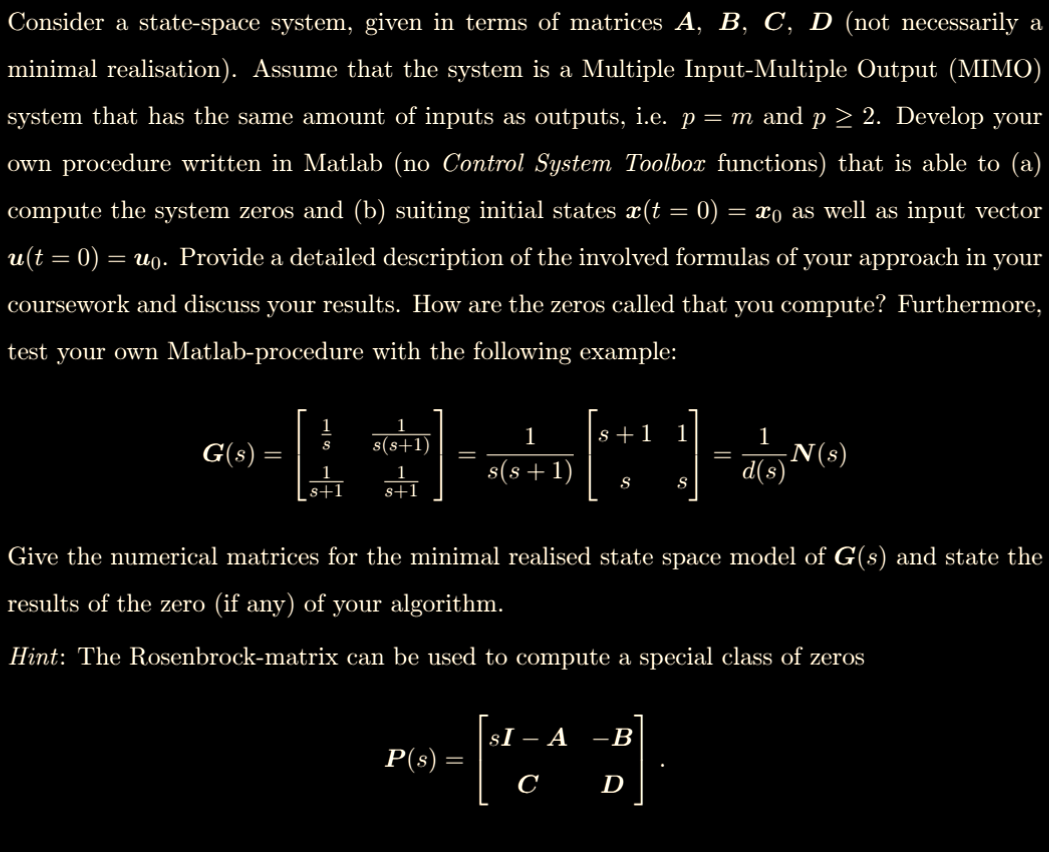

In [3]:
import numpy as np
import control as ct
import scipy as sp

p = 4  # input size
m = p  # output size
sys = ct.rss(4, m, p)
A = sys.A
B = sys.B
C = sys.C
D = sys.D

In [4]:
def getZeros(A, B, C, D):
    import numpy as np
    from scipy.linalg import eigvals, block_diag

    n = A.shape[0]
    m = C.shape[0]
    p = B.shape[1]

    # Construct the augmented matrix for zeros calculation
    L = np.block([
        [A, B],
        [C, D]
    ])
    M = np.pad(np.eye(A.shape[0]), ((0, C.shape[0]),
                                           (0, B.shape[1])), "constant")
    
    # Compute eigenvalues of the augmented matrix
    zeros = eigvals(L,M)

    # Filter out infinite or very large eigenvalues (numerical stability)
    zeros = [z for z in zeros if np.isfinite(z) and abs(z) < 1e6]

    return zeros

In [5]:
j = complex(0,1)

In [6]:
zeros = getZeros(A, B, C, D)
type(zeros)
zeros

[]

In [7]:
sys.zeros()  # Invariant Zeros

array([], dtype=float64)

In [8]:
# check if buildin control lib and getZeros give same result, give a msg
# assert np.isclose(zeros, sys.zeros()).any()

2.1.2 System zeros: Part II

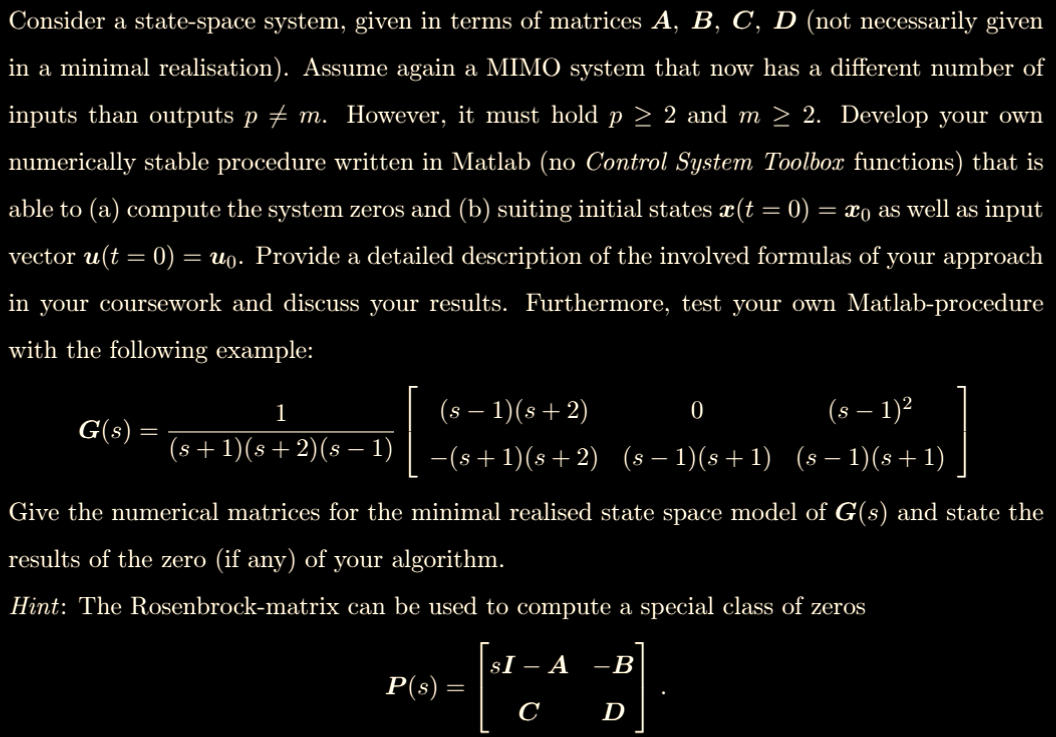

In [9]:
# clear only vars not imported libs
del A, B, C, D, j, m, p, sys, zeros, sp, ct, getZeros

In [10]:
import numpy as np
import control as ct
import scipy as sp
import sympy as sym

IN_CHANNELS = 2
OUT_CHANNELS = 3
STATES = 4

sys = ct.rss(STATES, OUT_CHANNELS, IN_CHANNELS)
A, B, C, D = sys.A, sys.B, sys.C, sys.D
print("Zeros:", sys.zeros())
print("Poles:", sys.poles())

Zeros: []
Poles: [-19.12160053+0.j         -5.23973586+0.j         -2.05793392+0.5962031j
  -2.05793392-0.5962031j]


In [11]:
sys.zeros()

array([], dtype=float64)

In [12]:
sys = ct.minreal(sys)
A, B, C, D = sys.A, sys.B, sys.C, sys.D

0 states have been removed from the model


In [13]:
z = sym.symbols('z')

# Ge and Ge_z are given example

Ge_z = (1/((z+1)*(z+2)*(z-1)))*sym.Matrix([
    [(z-1)*(z+2), 0, (z-1)**2],
    [-(z+1)*(z+2), (z-1)*(z+1), (z-1)*(z+1)] 
    ])

In [14]:
Ge_z = sym.simplify(Ge_z.expand())
Ge_z

Matrix([
[ 1/(z + 1),         0, (z - 1)/(z**2 + 3*z + 2)],
[-1/(z - 1), 1/(z + 2),                1/(z + 2)]])

In [15]:
num = [
    [[1], [0], [1, -1]],
    [[-1], [1], [1]],
]
den = [
    [[1, 1, 1], [1, 1, 1], [1, 3, 2]],
    [[-1], [1, 2], [1, 2]]
]
Ge = ct.tf(num, den)

In [16]:
# Create transfer function matrix from state-space without control lib
I = sym.eye(A.shape[0])
zI_A = z*I - sym.Matrix(A)
zI_A_inv = zI_A.inv()
B_spy = sym.Matrix(B)
C_spy = sym.Matrix(C)
D_spy = sym.Matrix(D)
G = C_spy * zI_A_inv * B_spy + D_spy

In [17]:
G

Matrix([
[0.225919526513754*(-12.05050624272*z**2 - 262.282259151615*z - 639.715279348449)/(1.0*z**4 + 28.47720422221*z**3 + 205.05072701063*z**2 + 524.2095265152*z + 459.937025084113) - 0.0474423321231131*(-9.0563549695285*z**2 + 57.1286863464338*z + 232.605791490054)/(1.0*z**4 + 28.47720422221*z**3 + 205.05072701063*z**2 + 524.2095265152*z + 459.937025084113) - 0.175735323787465*(-8.12914791724558*z**2 - 71.3469663274471*z - 87.8472320219281)/(1.0*z**4 + 28.47720422221*z**3 + 205.05072701063*z**2 + 524.2095265152*z + 459.937025084113) - 0.301913549913216*(-4.27890549981912*z**2 - 96.370889720295*z - 288.972360125535)/(1.0*z**4 + 28.47720422221*z**3 + 205.05072701063*z**2 + 524.2095265152*z + 459.937025084113) + 0.0634008185502233*(-3.42878437259094*z**2 + 16.4208070429721*z + 103.226935746792)/(1.0*z**4 + 28.47720422221*z**3 + 205.05072701063*z**2 + 524.2095265152*z + 459.937025084113) - 0.670247945993494*(-3.34504863391095*z**2 - 69.6478518517026*z - 173.796480250914)/(1.0*z**4 + 28

In [18]:
def detWithout(matrix, row_indices=None, col_indices=None):
    sub_matrix = matrix.copy()
    if row_indices is not None:
        sub_matrix = np.delete(sub_matrix, row_indices, axis=0)
    if col_indices is not None:
        sub_matrix = np.delete(sub_matrix, col_indices, axis=1)
    minor_val = np.linalg.det(sub_matrix)
    return minor_val

In [19]:
def getMinors(matrix, order):
    num_rows, num_cols = matrix.shape
    logger.debug(f"Matrix shape: {num_rows} rows, {num_cols} cols. Requested order: {order}")
    if order > max(num_rows, num_cols):
        raise ValueError('Order exceeds matrix dimensions', order, num_rows, num_cols)

    if order == num_rows:
        logger.debug("Calculating minors by column combinations.")
        from itertools import combinations
        col_comb = list(combinations(range(num_cols), order))
        minors_list = []
        for cols in col_comb:
            minor_matrix = matrix[:, cols]
            # minor_det = np.linalg.det(minor_matrix)
            minor_det = minor_matrix.det()
            minors_list.append(minor_det)
        return minors_list
    elif order == num_cols:
        logger.debug("Calculating minors by row combinations.")
        from itertools import combinations
        row_comb = list(combinations(range(num_rows), order))
        minors_list = []
        for rows in row_comb:
            minor_matrix = matrix[rows, :]
            minor_det = minor_matrix.det()
            minors_list.append(minor_det)
        return minors_list
    
    if order != num_rows and order != num_cols:
        logger.error("I have no idea to handle this case")  # #TODO lookup commercial implementations
        return

In [20]:
logger.setLevel(logging.DEBUG)
minors = getMinors(Ge_z, 2)

DEBUG:__main__:Matrix shape: 2 rows, 3 cols. Requested order: 2
DEBUG:__main__:Calculating minors by column combinations.


In [21]:
minors

[1/(z**2 + 3*z + 2), 2/(z**2 + 3*z + 2), (1 - z)/(z**3 + 5*z**2 + 8*z + 4)]

In [22]:
def lcdDenom(minors):
    denominators = [sym.denom(x) for x in minors]
    lcd = denominators[0]
    for denom in denominators[1:]:
        lcd = sym.lcm(lcd, denom)
    logger.debug(f'Least common denominator: {lcd}')
    return lcd

In [23]:
pole_poly = lcdDenom(minors)

DEBUG:__main__:Least common denominator: z**3 + 5*z**2 + 8*z + 4


In [24]:
quo = 1
sym.denom(quo)

1

In [25]:
def gcdNumAdjusted(minors, pole_poly):
    # Transform minors so that they have the common denominator pole_poly
    adjusted_minors = []
    for minor in minors:
        if sym.denom(minor) != pole_poly:
            quo = sym.denom(minors[1]) / pole_poly
            quo = sym.simplify(quo.expand(quo))
        else:
            quo = 1
        if sym.numer(quo) != 1:
            logger.error(f"Have no idea how to adjust this minor, {minor} into have common denominator {pole_poly}")
        else:
            adjusted_minor = sym.numer(minor)*sym.denom(quo)
            adjusted_minors.append(adjusted_minor)
    numerators = [sym.numer(x) for x in adjusted_minors]
    gcd = numerators[0]
    for num in numerators[1:]:
        gcd = sym.gcd(gcd, num)
    logger.debug(f'Greatest common divisor: {gcd}')
    return gcd

In [26]:
gcdNumAdjusted(minors, pole_poly)

DEBUG:__main__:Greatest common divisor: 1


1

In [27]:
Ge_z.rank()

2

In [138]:
def zeroRectangleTf(G):
    rank = G.rank()
    minors = getMinors(G, rank)
    pole_poly = lcdDenom(minors)
    zero_poly = gcdNumAdjusted(minors, pole_poly)
    # zeros = sym.roots(zero_poly)
    # A more effiecient way to get zeros from zero_poly
    zeros = sym.solve(zero_poly, sym.symbols('z'))
    return zeros

In [140]:
def poleRectangleTf(G):
    rank = G.rank()
    minors = getMinors(G, rank)
    pole_poly = lcdDenom(minors)
    # zeros = sym.roots(zero_poly)
    # A more effiecient way to get zeros from zero_poly
    poles = sym.solve(pole_poly, sym.symbols('z'))
    return poles

In [29]:
# zeroRectangleTf(G)

In [131]:
def zeroRectangle(A, B, C, D):
    z = sym.symbols('z')
    I = sym.eye(A.shape[0])
    zI_A = z*I - sym.Matrix(A)
    zI_A_inv = zI_A.inv()
    B_spy = sym.Matrix(B)
    C_spy = sym.Matrix(C)
    D_spy = sym.Matrix(D)
    G = C_spy * zI_A_inv * B_spy + D_spy
    zeros = zeroRectangleTf(G)
    return zeros


In [31]:
sys = ct.rss(states=2, outputs=2, inputs=2)
sys = ct.minreal(sys)
print(sys.zeros())
print(sys.poles())
A, B, C, D = sys.A, sys.B, sys.C, sys.D

0 states have been removed from the model
[]
[-0.53908869+0.j -0.7450943 +0.j]


In [32]:
# getZeros(A, B, C, D) # TODO: change to zeroSquare()

In [33]:
# zeroRectangle(A, B, C, D)

2.1.3 Perturbation and Internal Stability


In [118]:
num = [
    [[1], [0]], 
    [[0], [2]]
    ]
den = [
    [[1, 1], [1]], 
    [[1], [1, 2]]
    ]
G = ct.tf(num,den)
l = np.array([[7, 8], [6, 7]])
G = l * G * np.linalg.inv(l)
G = ct.minreal(G, tol=1e-3)

K = ct.tf([[[1], [0]], [[0], [1]]], [[[1], [1]], [[1], [1]]])
K = ct.minreal(K, tol=1e-3)

0 states have been removed from the model
0 states have been removed from the model


In [119]:
print(G)

<TransferFunction>: sys[119]
Inputs (2): ['u[0]', 'u[1]']
Outputs (2): ['y[0]', 'y[1]']

Input 1 to output 1:

    -47 s + 2
  -------------
  s^2 + 3 s + 2

Input 1 to output 2:

      -42 s
  -------------
  s^2 + 3 s + 2

Input 2 to output 1:

      56 s
  -------------
  s^2 + 3 s + 2

Input 2 to output 2:

    50 s + 2
  -------------
  s^2 + 3 s + 2


In [132]:
# Create a function that converts a Python-Control TransferFunction to a SymPy Matrix of TransferFunctions
# Replace the complex var with sym.symbol('s')
def ctTfToSympyMatrix(tf):
    num = tf.num
    den = tf.den
    rows = len(num)
    cols = len(num[0])
    sympy_matrix = sym.Matrix.zeros(rows, cols)
    for i in range(rows):
        for j in range(cols):
            numerator = sym.Poly(np.round(num[i][j], decimals=6), sym.symbols('z')).as_expr()
            denominator = sym.Poly(np.round(den[i][j], decimals=6), sym.symbols('z')).as_expr()
            sympy_matrix[i, j] = numerator / denominator
    return sympy_matrix

# Example usage
sympy_matrix = ctTfToSympyMatrix(G)
sympy_matrix

Matrix([
[(2.0 - 47.0*z)/(1.0*z**2 + 3.0*z + 2.0),         56.0*z/(1.0*z**2 + 3.0*z + 2.0)],
[       -42.0*z/(1.0*z**2 + 3.0*z + 2.0), (50.0*z + 2.0)/(1.0*z**2 + 3.0*z + 2.0)]])

In [133]:
G_z = ctTfToSympyMatrix(G)
K_z = ctTfToSympyMatrix(K)

In [151]:
K_z

Matrix([
[1.0,   0],
[  0, 1.0]])

In [152]:
G_z

Matrix([
[(2.0 - 47.0*z)/(1.0*z**2 + 3.0*z + 2.0),         56.0*z/(1.0*z**2 + 3.0*z + 2.0)],
[       -42.0*z/(1.0*z**2 + 3.0*z + 2.0), (50.0*z + 2.0)/(1.0*z**2 + 3.0*z + 2.0)]])

In [143]:
# (I+G_z*K_z)^-1
first_cl = (sym.eye(2)+K_z*G_z).inv()  # specify tol to avoid singularity error
# G*(I + K*G)^-1
second_cl = G_z*first_cl

third_cl = -K_z*(sym.eye(2)+G_z*K_z).inv()

four_cl = (sym.eye(2)+G_z*K_z).inv()



In [135]:

first_cl

Matrix([
[(1.0*z**2 + 53.0*z + 4.0)/(1.0*z**2 + 6.0*z + 8.0),                   -56.0*z/(1.0*z**2 + 6.0*z + 8.0)],
[                   42.0*z/(1.0*z**2 + 6.0*z + 8.0), (1.0*z**2 - 44.0*z + 4.0)/(1.0*z**2 + 6.0*z + 8.0)]])

In [144]:
poleRectangleTf(first_cl)

DEBUG:__main__:Matrix shape: 2 rows, 2 cols. Requested order: 2
DEBUG:__main__:Calculating minors by column combinations.
DEBUG:__main__:Least common denominator: 1.0*z + 4.0


[-4.00000000000000]

In [147]:
poleRectangleTf(second_cl)


DEBUG:__main__:Matrix shape: 2 rows, 2 cols. Requested order: 2
DEBUG:__main__:Calculating minors by column combinations.
DEBUG:__main__:Least common denominator: 1.0*z**2 + 6.0*z + 8.0


[-4.00000000000000, -2.00000000000000]

In [148]:
poleRectangleTf(third_cl)

DEBUG:__main__:Matrix shape: 2 rows, 2 cols. Requested order: 2
DEBUG:__main__:Calculating minors by column combinations.
DEBUG:__main__:Least common denominator: 1.0*z + 4.0


[-4.00000000000000]

In [149]:
poleRectangleTf(four_cl)

DEBUG:__main__:Matrix shape: 2 rows, 2 cols. Requested order: 2
DEBUG:__main__:Calculating minors by column combinations.
DEBUG:__main__:Least common denominator: 1.0*z + 4.0


[-4.00000000000000]

In [1]:
import dkpy

In [7]:
Delta =dkpy.RealDiagonalBlock(2)

In [ ]:
# P = dkpy.(
#     systems={
#         "G0": G0,
#         "Wa": Wa,
#         "Delta": Delta
#     },
#     connections=[
#         ("G0.u", "u"),
#         ("Wa.u", "u"),
#         ("Delta.u", "Wa.y"),
#         ("y", "G0.y + Delta.y")
#     ],
#     inputs=["u"],
#     outputs=["y"]
# )


AttributeError: module 'dkpy' has no attribute 'interconnect'

In [2]:
Delta = dkpy.DeltaFull(name="Delta", size=(1,1))

AttributeError: module 'dkpy' has no attribute 'DeltaFull'